In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib notebook

In [3]:
import numpy as np

import pandas as pd

from sklearn import decomposition, manifold

import plotnine as pn
import seaborn as sns

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


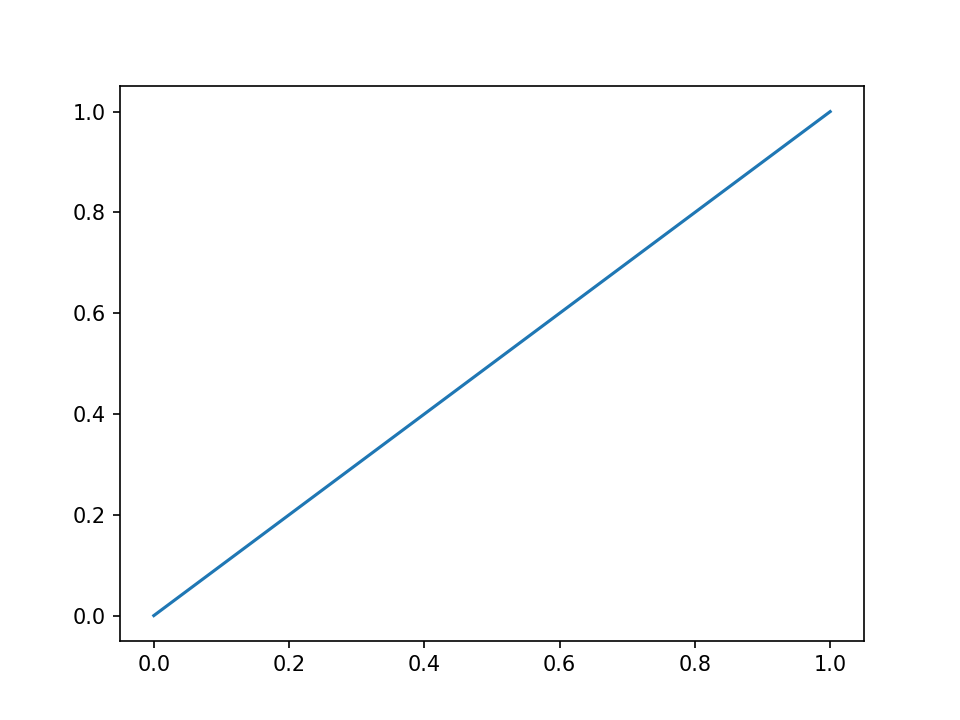

In [4]:
plt.plot([0,1])

In [6]:
import train_nn_ebm
from train_nn_ebm import *

In [29]:
%matplotlib inline

In [7]:
BASE_DIR='./experiment/conv1_semisup/'
BASE_DIR='./experiment/conv1_semisup_lowlr/'

BASE_DIR='./experiment/conv1_sup_sm2/'
args = argparse.Namespace(**json.load(open(f'{BASE_DIR}/params.txt')))
args.load_path = f'{BASE_DIR}/last_ckpt.pt'
train_nn_ebm.args = args

In [8]:
t.manual_seed(args.t_seed)
if t.cuda.is_available():
    t.cuda.manual_seed_all(args.t_seed)
    
if args.dataset == "mnist":
    args.n_ch = 1
    args.im_sz = 28
elif (args.dataset == "moons" or args.dataset == "rings"):
    args.n_ch = 1
    args.im_sz = None
elif args.dataset in REG_DSETS:
    args.n_ch = 1
    args.im_sz = None
else:
    args.n_ch = 3
    args.im_sz = 32

# datasets
dload_train, dload_train_labeled, dload_valid, dload_test, dset_train, \
dset_train_labeled, dload_train_labeled_static, dload_train_vbnorm = get_data(args)

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [9]:
ref_x = None
f, replay_buffer = get_model_and_buffer(args, device, ref_x)

SmallConvNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=1250, out_features=312, bias=True)
    (1): ReLU()
    (2): Linear(in_features=312, out_features=78, bias=True)
    (3): ReLU()
    (4): Linear(in_features=78, out_features=19, bias=True)
    (5): ReLU()
    (6): Linear(in_features=19, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=2, bias=True)
  )
)
loading model from ./experiment/conv1_sup_sm2//last_ckpt.pt


In [10]:
unsup_batch = next(iter(dload_train))
sup_batch = next(iter(dload_train_labeled))
test_batch = next(iter(dload_test))

In [11]:
unsup_pre_sm = f.penult(unsup_batch[0].cuda())
sup_pre_sm = f.penult(sup_batch[0].cuda())
test_pre_sm = f.penult(test_batch[0].cuda())
sm_w = f.class_output.weight

In [12]:
all_vecs = np.concatenate([
    unsup_pre_sm.detach().cpu().numpy(),
    sup_pre_sm.detach().cpu().numpy(),
    test_pre_sm.detach().cpu().numpy(),
    sm_w.detach().cpu().numpy(),
], axis=0)

all_attribs = pd.concat([
    pd.DataFrame(dict(y=unsup_batch[1], 
                      kind=['unsup']*unsup_batch[1].shape[0])),
    pd.DataFrame(dict(y=sup_batch[1], 
                      kind=['sup']*sup_batch[1].shape[0])),
    pd.DataFrame(dict(y=test_batch[1], 
                      kind=['test']*test_batch[1].shape[0])),
    pd.DataFrame(dict(y=range(10), 
                      kind=['sm']*10)),
])

In [66]:
all_attribs['norm'] = np.sqrt((all_vecs**2).sum(-1))

In [67]:
all_attribs['preds'] = (all_vecs @ sm_w.detach().cpu().numpy().T + f.class_output.bias.detach().cpu().numpy()).argmax(1)
all_attribs['correct'] = all_attribs.y == plot_df.preds

In [68]:
assert len(all_vecs) == len(all_attribs)

In [69]:
all_vecs_n = all_vecs / np.sqrt((all_vecs**2).sum(-1, keepdims=True))

In [70]:
if 0:
    tsne = manifold.TSNE()

    all_tsne = tsne.fit_transform(all_vecs)
    all_attribs['TX0'] = all_tsne[:, 0]
    all_attribs['TX1'] = all_tsne[:, 1]
else:
    assert all_vecs.shape[1] == 2
    all_attribs['TX0'] = all_vecs[:, 0]
    all_attribs['TX1'] = all_vecs[:, 1]

In [71]:
all_attribs['Ystr'] = all_attribs.y.apply(lambda x: f':{x}')

<IPython.core.display.Javascript object>


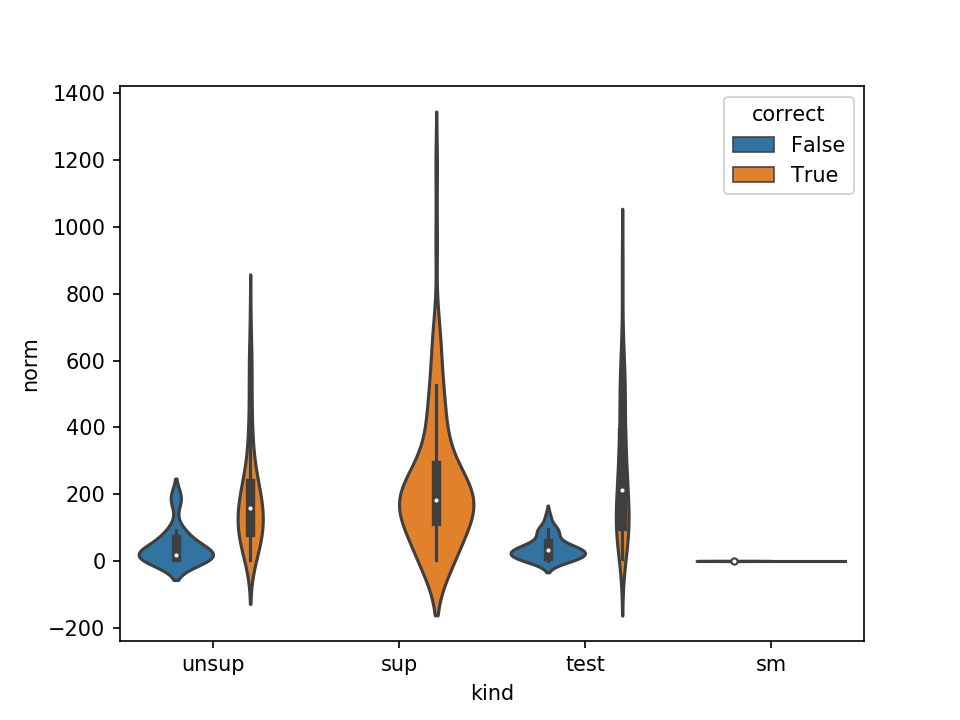

In [73]:
sns.violinplot(x='kind', y='norm', hue='correct', data=all_attribs)

In [83]:
sup_batch[0].min()

tensor(-1.1075)

In [59]:
%matplotlib notebook

<IPython.core.display.Javascript object>


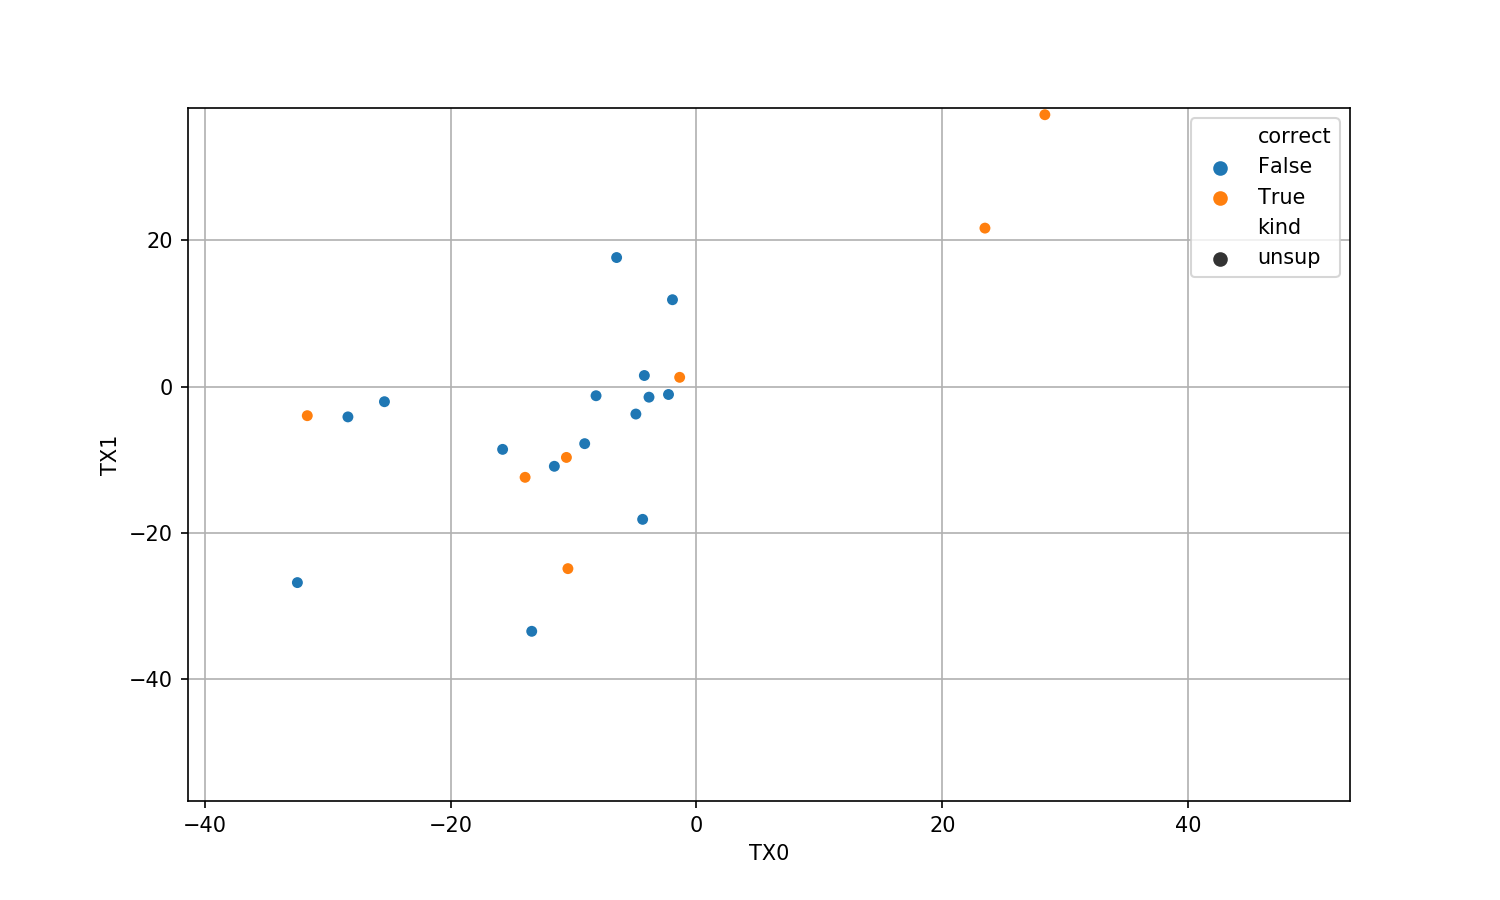

In [75]:
plot_df = all_attribs
plot_df = plot_df[plot_df.kind == 'unsup']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TX0', y='TX1', hue='correct', style='kind', data=plot_df)
plt.legend(loc='upper right')
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.grid()

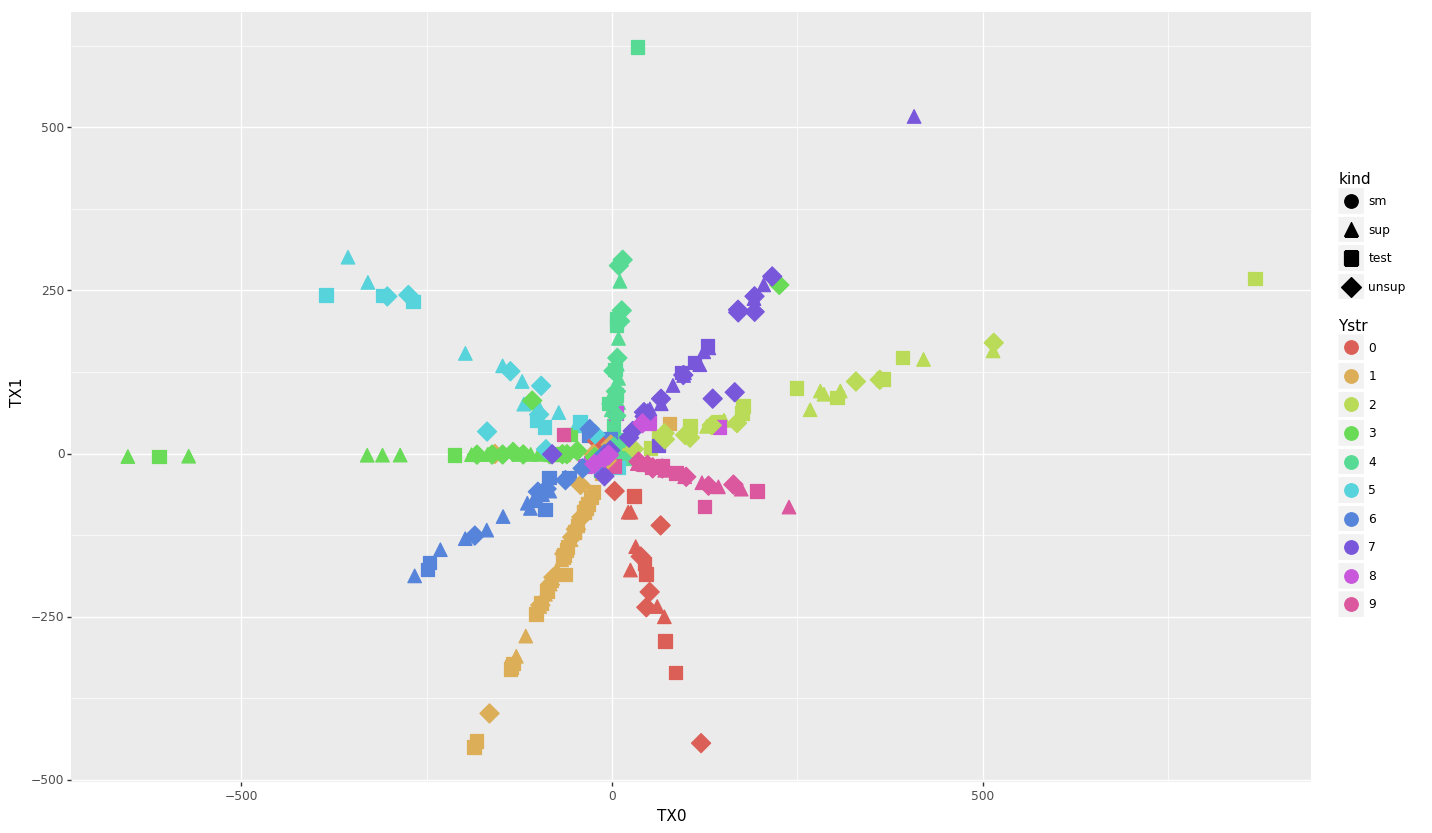

<ggplot: (8758046698816)>

In [30]:
plot_df = all_attribs
# plot_df = plot_df[plot_df.kind != 'sm']
p = (
    pn.ggplot(pn.aes(x='TX0', y='TX1', color='Ystr', shape='kind'), plot_df)
    + pn.geom_point(size=5)
    + pn.theme(figure_size=(16,10))
)
p

In [24]:
sup_preds = f.classify(sup_batch[0].cuda()).argmax(-1).cpu()
(sup_preds == sup_batch[1]).float().mean()

tensor(1.)

In [25]:
test_preds = f.classify(test_batch[0].cuda()).argmax(-1).cpu()
(test_preds == test_batch[1]).float().mean()

tensor(0.7300)